In [156]:
import random
class BlackJackEnv:

  rCount = 0
  roundStarted = False

  def __str__(self):
    return f"Deck: {self.deck} \nDiscard: {self.discard} \nRunning Count: {self.rCount} \nPlayer Hand: {self.playerHand} \nDealer Hand: {self.dealerHand} \nRound Started: {self.roundStarted}\n hasAce: {self.has_ace()} \n"

  def __init__(self, numDecks, tie_reward=5.0):
    self.deck = [2,3,4,5,6,7,8,9,10,10,10,10,11] * 4 * numDecks #ingoring suits, not needed for blackjack
    self.rCount = 0 #Wont update for now, will just keep discrad pile and create method to update later
    self.discard = [] #Also contains cards that are in play (on the table)
    self.playerHand = []
    self.dealerHand = []
    self.doubled = False
    self.tie_reward = tie_reward
    
    self.shuffle()

  
  def shuffle(self):
    for card in self.discard:
      self.deck.append(card)
    self.discard = []
    self.rCount = 0
    #shuffle 5 times
    for i in range (5):
      random.shuffle(self.deck)

  def hand_value(self,hand):
    value = sum(hand)
    if value > 21 and 11 in hand:
      hand.remove(11)
      hand.append(1)
      value = sum(hand)
    return value
  

  #might need to change this account for aces that are already overdrawn for value 11
  def has_ace(self):
    if 11 in self.playerHand:
      return 1
    else:
      return 0
  
  def deal_card(self):
    card = self.deck.pop()
    if card < 7:
      self.rCount += 1
    elif card > 9:
      self.rCount -= 1
    self.discard.append(card)
    return card
  
  def get_state(self):
    """
     Returns: player hand-val, dealers first card, hasAce, roundstarted(bbool), reward
     """
    pl = self.hand_value(self.playerHand)
    dl = self.dealerHand[0]
    runningCount = self.get_rCount()
    reward = self.get_reward()
    roundStarted = self.roundStarted
    #Returns: player hand-val, dealers first card, hasAce, roundstarted(bbool), reward
    return (pl,dl,self.has_ace(), roundStarted,reward,runningCount, self.doubled)
  
  def get_rCount(self):
    if self.rCount > 2:
      return 2
    elif self.rCount < -2:
      return 0
    else:
      return 1
  


  def get_reward(self):
    if self.roundStarted:
      return 0.0
    else:

      playerValue = self.hand_value(self.playerHand)
      dealerValue = self.hand_value(self.dealerHand)
      if playerValue > 21:
        return -200.0 if self.doubled else -100.0
      if dealerValue > 21:
        return 200.0 if self.doubled else 100.0
      if playerValue > dealerValue:
        return 200.0 if self.doubled else 100.0
      if playerValue < dealerValue:
        return -200.0 if self.doubled else -100.0
      return self.tie_reward
    
  def end_round(self):
   
    self.playerHand = []
    self.dealerHand = []
    

  def start_round(self):
    self.doubled = False
    if len(self.deck) < 15:
      self.shuffle()
    
    if self.roundStarted:
      print("Round already started")
      return None
    self.roundStarted = True
    self.playerHand = [self.deal_card(), self.deal_card()]
    self.dealerHand = [self.deal_card(), self.deal_card()]
    if self.hand_value(self.playerHand) == 21:
      self.roundStarted = False
      state = self.get_state()
      self.end_round()
      return state
    return self.get_state()

  def next(self,action):
    if not self.roundStarted:
      print("Round not started")
      return None
    
    if action == 1:
      self.playerHand.append(self.deal_card())
      if self.hand_value(self.playerHand) > 21:
        self.roundStarted = False
        state = self.get_state()
        self.end_round()
        return state
      return self.get_state()
    
    elif action == 0:
      
      while self.hand_value(self.dealerHand) < 17:
        self.dealerHand.append(self.deal_card())
      self.roundStarted = False
      state = self.get_state()
      self.end_round()
      return state
    
    elif action == 2:
      self.doubled = True
      self.playerHand.append(self.deal_card())
      if self.hand_value(self.playerHand) > 21:
        self.roundStarted = False
        state = self.get_state()
        self.end_round()
        return state
      
      while self.hand_value(self.dealerHand) < 17:
        self.dealerHand.append(self.deal_card())
      self.roundStarted = False
      state = self.get_state()
      self.end_round()
      return state
    

    else:
      return None


In [157]:
MOVES = ['S', 'H', 'D']
def q_solve(env):
    

    #ROWS REPRESENT PLAYER TOTALS: 4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21 (18 total)
    #COLUMNS REPRESENT DEALER SHOWING: 2,3,4,5,6,7,8,9,10,11 (10 total)
    #HAS ACE: 0,1 (2 total)
    #RUNNING COUNT: 0,1,2 (3 total)
    # ACTION: HIT, STAY (2 total)
    r = 18
    c = 10
    
    qVals = [] # qvals[player][dealer][hasAce][rCount][action]
    #Initializing Qvals arr 
    for i in range(r):
        q_row = []
        for j in range(c):
            q_row.append([[[0.0,0.0,0.0],[0.0,0.0,0.0],[0.0,0.0,0.0]],[[0.0,0.0,0.0],[0.0,0.0,0.0],[0.0,0.0,0.0]]])
        
        qVals.append(q_row)
        
    #Learning
    for _ in range(ITERATIONS):
        #Random drop on the map
        
        pl,dl,hasAce, roundStarted,reward,rCount,_ = env.start_round()
        

        while True:
            #If we get dropped on p or g, its a terminal state and we end trial.
            if reward== 100.0:
                qVals[pl-4][dl-2][hasAce][rCount][0] = 100.0
                qVals[pl-4][dl-2][hasAce][rCount][1] = 100.0
                qVals[pl-4][dl-2][hasAce][rCount][2] = 100.0  
                break

            if reward == 200.0:
                qVals[pl-4][dl-2][hasAce][rCount][0] = 200.0
                qVals[pl-4][dl-2][hasAce][rCount][1] = 200.0
                qVals[pl-4][dl-2][hasAce][rCount][2] = 200.0
                break

            if reward== -100.0:
                qVals[pl-4][dl-2][hasAce][rCount][0] = -100.0
                qVals[pl-4][dl-2][hasAce][rCount][1] = -100.0
                qVals[pl-4][dl-2][hasAce][rCount][2] = -100.0
                break 
            if reward== -200.0:
                qVals[pl-4][dl-2][hasAce][rCount][0] = -200.0
                qVals[pl-4][dl-2][hasAce][rCount][1] = -200.0
                qVals[pl-4][dl-2][hasAce][rCount][2] = -200.0
                break
            if reward== 5.0:
                qVals[pl-4][dl-2][hasAce][rCount][0] = 5.0
                qVals[pl-4][dl-2][hasAce][rCount][1] = 5.0
                qVals[pl-4][dl-2][hasAce][rCount][2] = 5.0
                break 
            pr = random.random()
            possible_moves = [0,1,2] #add double later
            action = 0
            #WIth prob EXPLORE_PROB we pick a random possible move, otherwise we pick best q
            # Might also want to add always hit under 12 rule
            if pr < EXPLORE_PROB:
                action = random.choice(possible_moves)
            else:
                
                best_action_q = max(qVals[pl-4][dl-2][hasAce][rCount])
                action = qVals[pl-4][dl-2][hasAce][rCount].index(best_action_q)

            
            pl_new,dl_new,hasAce_new, roundStarted_new,reward,rCount_new,doubled = env.next(action)
            # Second check for terminal state
            
            #calling new_q to update current q
            q = new_q(reward,hasAce,qVals,pl,dl,rCount,pl_new,dl_new,hasAce_new,rCount_new,action,doubled)
            #Updating q in qvals arr
            qVals[pl-4][dl-2][hasAce][rCount][action] = q
            if reward != 0.0:
                break
            #Moving on if not terminal state
            pl = pl_new
            dl= dl_new
            hasAce = hasAce_new
            


    return get_policy(qVals)



#Helper function to return the possible moves from a specific square (to avoid going off map)


#Helper function to get the reward for a coordinate
def get_policy(qVals):
       
        aces = []
        no_aces = []
        for count in range (0,3):
            ace_policy = []
            policy = []

            for i in range(4, 22):
                ace_row = []
                row = []
                for j in range(2, 12):
                    best_action_index = qVals[i-4][j-2][0][count].index(max(qVals[i-4][j-2][0][count])) 
                    best_action = MOVES[best_action_index]
                    row.append(best_action)
                    best_action_index_ace = qVals[i-4][j-2][1][count].index(max(qVals[i-4][j-2][1][count])) 
                    best_action_ace = MOVES[best_action_index_ace]
                    ace_row.append(best_action_ace)
                policy.append(row)
                ace_policy.append(ace_row)
            aces.append(ace_policy)
            no_aces.append(policy)


        
        return (no_aces, aces)

#Q learning function uses
def new_q(action_reward,hasAce, qVals, pl_old, dl_old,rCount, pl_new, dl_new,hasAce_new,rCount_new, movenum,doubled):
   
    old_q = qVals[pl_old-4][dl_old-2][hasAce][rCount][movenum]
    if pl_new == 21:
        best_next_q = 200.0 if doubled else 100.0
    elif pl_new > 21:
        best_next_q = -200.0 if doubled else -100.0
    else:

        best_next_q = max(qVals[pl_new-4][dl_new-2][hasAce_new][rCount_new])

    new_q = old_q + LEARNING_RATE * (action_reward + DISCOUNT_FACTOR * best_next_q - old_q)


    return new_q

In [166]:
def try_policy(policy,ace_policy):
  env = BlackJackEnv(3)
  rewards = 0.0
  wins = 0
  moves = {'H':1,'S':0,'D':2}
  for _ in range(200000):
    pl,dl,hasAce, _,reward,rCount,_ = env.start_round()
    while True:
            #If we get dropped on p or g, its a terminal state and we end trial.
            if reward== 100.0:
                rewards += 100.0 
                wins += 1
                break
            if reward == 200.0:
                rewards += 200.0
                wins += 1
                break

            if reward== -100.0:
                rewards -= 100.0
                break 
            if reward== -200.0:
                rewards -= 200.0
                break
            if reward== 5.0:
                rewards += 5.0
                break 
            if hasAce:
                action = moves[ace_policy[rCount][pl-4][dl-2]]
            else:
                action = moves[policy[rCount][pl-4][dl-2]]
            #Take action and get new state
            
            pl, dl, hasAce, _, reward,rCount,_ = env.next(action)
  return rewards/200000, wins/200000
    

In [142]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

def map_policies(policies):
    # Constants
    player_values = list(range(4, 22))
    dealer_cards = list(range(2, 12))
    
    # Create subplots for each policy
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
    
    for idx, policy in enumerate(policies):
        # Map 'H' to 0, 'S' to 1, and 'D' to 2 for numerical representation
        strategy_numerical = [[0 if cell == 'H' else 1 if cell == 'S' else 2 if cell == 'D' else cell for cell in row] for row in policy]
        strategy_df = pd.DataFrame(policy, index=player_values, columns=dealer_cards)
        strategy_df_numerical = pd.DataFrame(strategy_numerical, index=player_values, columns=dealer_cards)
        
        # Plot each heatmap in its subplot
        sns.heatmap(strategy_df_numerical, annot=strategy_df, cmap='YlGnBu', fmt='', cbar=False, ax=axes[idx])
        axes[idx].set_title(f"Policy for count {['< -2', 'neutral', '> 2'][idx]} (H=Hit, S=Stand, D=Double)")
        axes[idx].set_xlabel("Dealer's Face-Up Card")
        axes[idx].set_ylabel("Player's Total" if idx == 0 else "")
    
    plt.tight_layout()
    plt.show()


In [159]:
table = BlackJackEnv(3)
print(table)

Deck: [10, 11, 3, 10, 10, 3, 10, 5, 3, 11, 4, 9, 4, 9, 6, 2, 8, 8, 8, 9, 5, 10, 2, 10, 10, 9, 8, 11, 11, 2, 3, 10, 11, 7, 10, 10, 10, 10, 10, 9, 10, 10, 10, 8, 7, 10, 6, 8, 7, 4, 11, 8, 4, 5, 6, 6, 9, 8, 7, 5, 2, 9, 9, 2, 4, 4, 2, 6, 3, 4, 6, 7, 6, 11, 3, 10, 10, 10, 2, 10, 9, 11, 9, 10, 6, 2, 4, 4, 6, 2, 8, 7, 2, 5, 10, 10, 9, 6, 6, 10, 10, 7, 3, 8, 10, 4, 5, 10, 10, 10, 10, 6, 10, 10, 7, 10, 4, 7, 5, 10, 5, 3, 3, 2, 10, 10, 2, 11, 11, 7, 10, 10, 10, 7, 10, 5, 11, 3, 5, 10, 8, 10, 10, 10, 5, 10, 11, 9, 3, 10, 8, 5, 10, 3, 7, 4] 
Discard: [] 
Running Count: 0 
Player Hand: [] 
Dealer Hand: [] 
Round Started: False
 hasAce: 0 



In [163]:
print(table.next(0))

Round not started
None


In [149]:
LEARNING_RATE = 0.01
DISCOUNT_FACTOR = 0.4
EXPLORE_PROB = 0.8 # for Q-learning
table = BlackJackEnv(10)

(no_aces,aces) = q_solve(table)


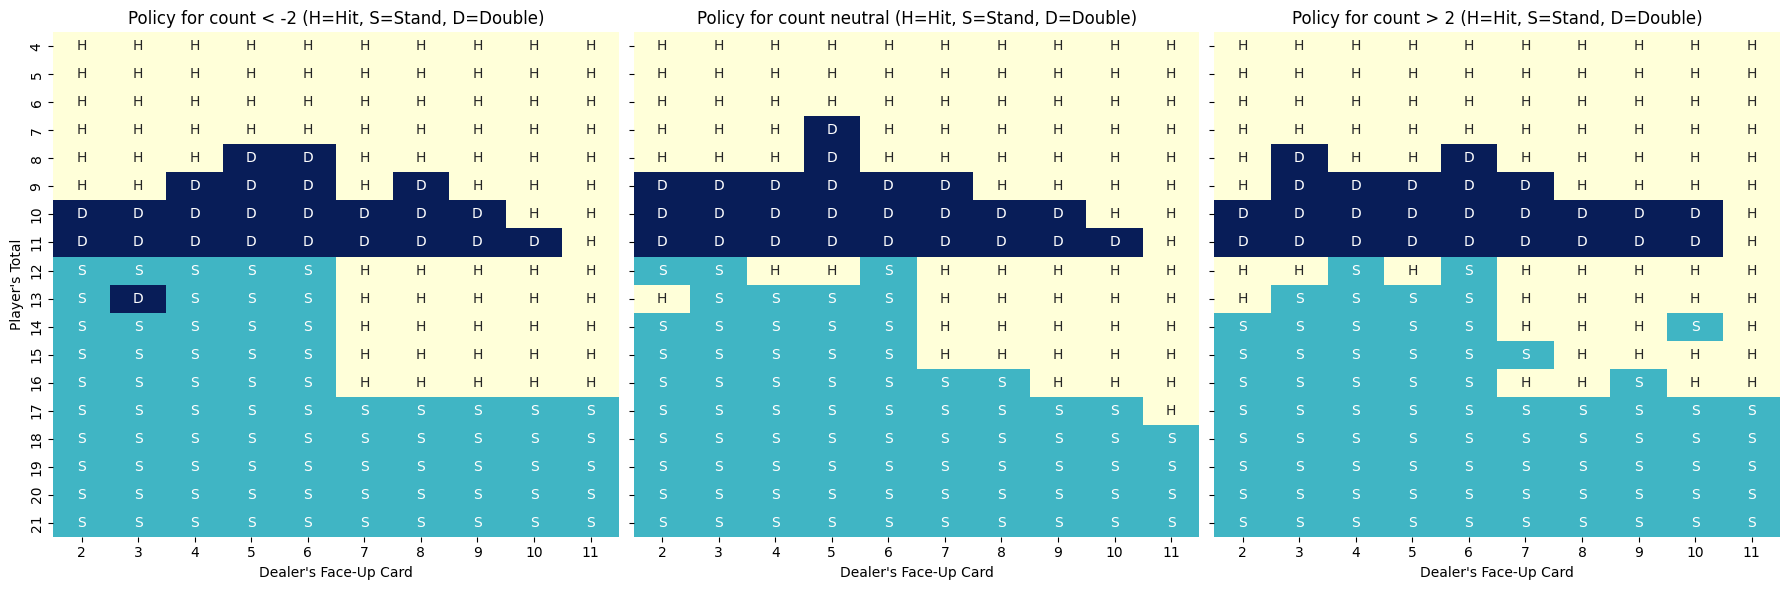

In [151]:
map_policies(no_aces)

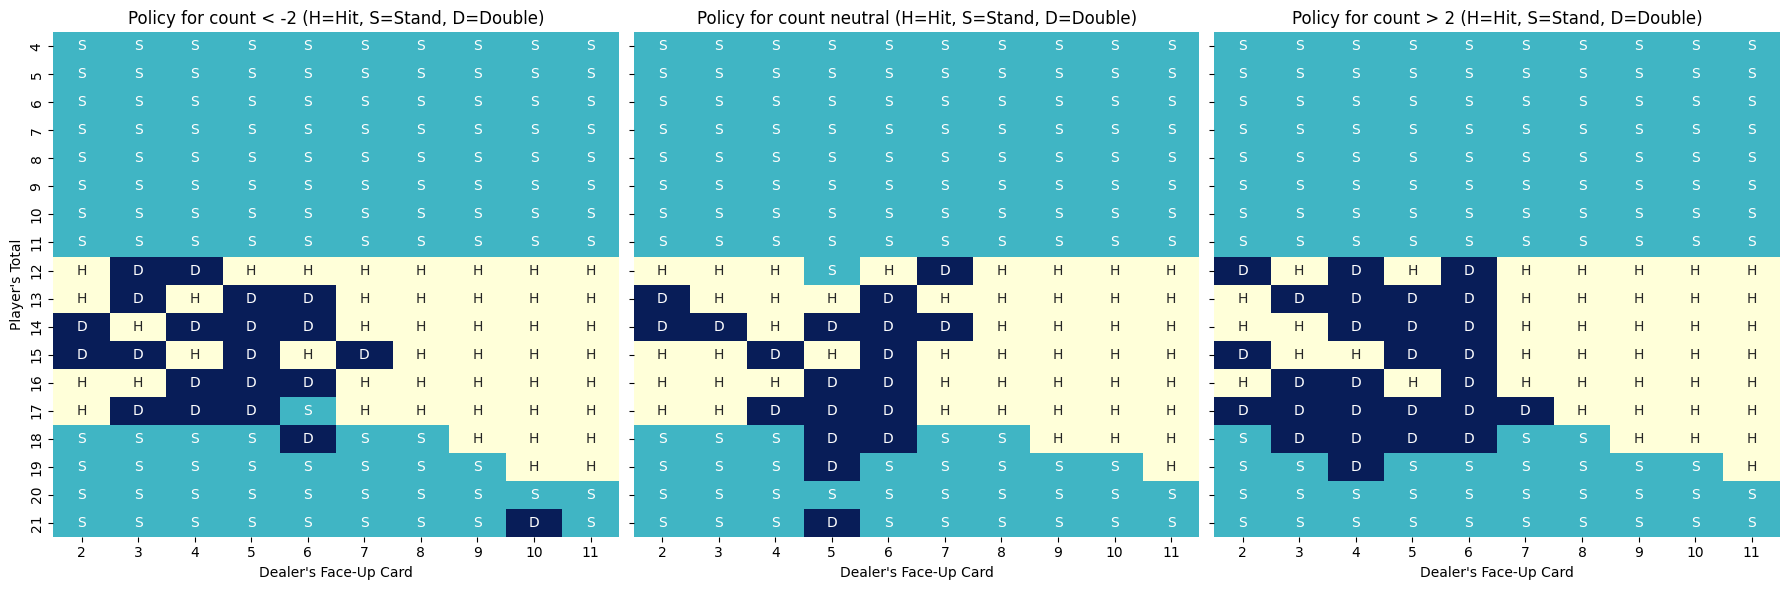

In [152]:
map_policies(aces)

In [167]:

try_policy(no_aces,aces)

(-2.60295, 0.43213)